In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from oxfordiit_pet_dataset import get_datasets
from torchvision import datapoints
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from time import sleep
seed = 42
torch.manual_seed(seed)

/home/giangi/Workspace/Applications/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/giangi/Workspace/Applications/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change 

In [2]:
#Playing around to get a fast way to get the patches in correct order (left to right, bottom to top) using views.
#Order at the end should not matter as long as is consistent. The positional emb_size_size_size_sizeedding will learn the order (like right to left, top to bottom for instance instead of the one above)
sz0 = 10
sz1 = 10
a = torch.zeros(3,2,sz0,sz1)
cnt = 0
stride = 5
new_dim0 = sz0//stride
new_dim1 = sz1//stride
for k in range(a.shape[1]):
    for i in range(new_dim0):
        for j in range(new_dim1):
            a[:,k,i*stride:(i+1)*stride,j*stride:(j+1)*stride] = cnt
            cnt += 1
print(a[0])
print(a[0,0].view(new_dim0,stride,sz1))
print(a[0,0].view(new_dim0,stride,new_dim1,stride).permute(0,2,1,3))

tensor([[[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 3., 3., 3., 3., 3.],
         [2., 2., 2., 2., 2., 3., 3., 3., 3., 3.],
         [2., 2., 2., 2., 2., 3., 3., 3., 3., 3.],
         [2., 2., 2., 2., 2., 3., 3., 3., 3., 3.],
         [2., 2., 2., 2., 2., 3., 3., 3., 3., 3.]],

        [[4., 4., 4., 4., 4., 5., 5., 5., 5., 5.],
         [4., 4., 4., 4., 4., 5., 5., 5., 5., 5.],
         [4., 4., 4., 4., 4., 5., 5., 5., 5., 5.],
         [4., 4., 4., 4., 4., 5., 5., 5., 5., 5.],
         [4., 4., 4., 4., 4., 5., 5., 5., 5., 5.],
         [6., 6., 6., 6., 6., 7., 7., 7., 7., 7.],
         [6., 6., 6., 6., 6., 7., 7., 7., 7., 7.],
         [6., 6., 6., 6., 6., 7., 7., 7., 7., 7.],
         [6., 6., 6., 6., 6., 7., 7., 7., 7., 7.],
         [6., 6., 6., 6., 6.,

In [3]:
#Function to get patches from an image. The number of patches will be equivalent of the time dimension for words
def get_patches(inp,patch_size):
    #Assume images are square like b x c x h x w and divisible by patch_size 
    ishape = inp.shape
    assert ishape[-1] == ishape[-2], 'Images must be square'
    assert (ishape[-1] % patch_size) == 0, 'Width and lenght must be divisibple by patch_size'
    new_dim = ishape[-2]//patch_size
    #reshape the last two dimensions, then permute (0,1,2,4,3,5) so that the last 2 dims are patch_size x patch_size.
    #permute again to put the channel next to height and width (0,2,3,1,4,5)
    ret =  inp.view(*ishape[:2],new_dim,patch_size,new_dim,patch_size).permute(0,1,2,4,3,5).permute((0,2,3,1,4,5))
    #ret.shape = b x h/patch_size x w/patch_size x c x patch_size x patch_size
    rshape = ret.shape
    #reshape into b x t x l with t = "timesteps" i.e. number of patches h/patch_size x w/patch_size and l = c x patch_size x patch_size
    #kind of the emb_sizeedding size 
    return ret.reshape((rshape[0],rshape[1]*rshape[2],-1))

class PositionalEmbeddingLearn():
    def __init__(self,max_seq_len,msize):
        self.max_seq_len = max_seq_len
        self.msize = msize
        self.create_pe()
    
    def create_pe(self):
            self.pe = nn.Embedding(self.max_seq_len,self.msize)
       
    def __call__(self,sel):
        return self.pe(sel)

class PositionalEmbeddingTrig():
    def __init__(self,max_seq_len,msize,base=10000):
        self.max_seq_len = max_seq_len
        self.msize = msize
        self.base = base
        self.create_pe()
    
    def create_pe(self):
        xi = np.arange(0,self.msize,2)
        x = np.zeros((self.max_seq_len,self.msize),np.int32)
        x[:,::2] = np.tile(xi,[self.max_seq_len,1])
        x[:,1::2] = np.tile(xi,[self.max_seq_len,1])
        pos = np.tile(np.arange(self.max_seq_len).reshape([-1,1]),[1,self.msize])
        self.pe = np.zeros_like(x,np.float32)
        self.pe[:,::2] = np.sin(pos[:,::2]/self.base**(x[:,::2]/self.msize))
        self.pe[:,1::2] = np.cos(pos[:,1::2]/self.base**(x[:,1::2]/self.msize))
        self.pe = torch.from_numpy(self.pe)

    def __call__(self,sel):
        return self.pe[sel]

def get_embedding(etype,max_seq_len,msize,base=10000):
    if etype == 'trig':
        return PositionalEmbeddingTrig(max_seq_len,msize,base)
    elif etype == 'learn':
        return PositionalEmbeddingLearn(max_seq_len,msize)
    else:
        raise ValueError(f'Unknown embedding type {etype}')

class SelfAttention(nn.Module):
    
    def __init__(self,emb_size,num_heads=8,mask=False):
        super().__init__()
        assert emb_size % num_heads == 0, f'Embedding size {emb_size} must be divisible by number of heads {num_heads}'

        self.num_heads = num_heads
        self.emb_size = emb_size
        self.mask = mask
        self.get_keys = nn.Linear(emb_size,emb_size,bias=False)
        self.get_queries = nn.Linear(emb_size,emb_size,bias=False)
        self.get_values = nn.Linear(emb_size,emb_size,bias=False)

        self.linear = nn.Linear(emb_size,emb_size)
    
    def apply_mask(self,x,mask_val=np.inf):
        h,w = x.size(-2),x.size(-1)
        indices = torch.triu_indices(h,w,offset=1)
        x[...,indices[0],indices[1]] = mask_val
        return x

    def forward(self,x):
        b,t,e = x.size()
        h = self.num_heads
        s = e // h

        keys = self.get_keys(x)
        queries = self.get_queries(x)
        values = self.get_values(x)

        keys = keys.view(b,t,h,s)
        queries = queries.view(b,t,h,s)
        values = values.view(b,t,h,s)

        keys = keys.transpose(1,2).contiguous().view(b*h,t,s)
        queries = queries.transpose(1,2).contiguous().view(b*h,t,s)
        values = values.transpose(1,2).contiguous().view(b*h,t,s)

        dot_qk = torch.bmm(queries,keys.transpose(1,2))/e**(1/2)

        if self.mask:
            dot_qk = self.apply_mask(dot_qk)
        dot_qk = F.softmax(dot_qk,dim=2)
        out = torch.bmm(dot_qk,values).view(b,h,t,s)
        out = out.transpose(1,2).contiguous().view(b,t,h*s)
        return self.linear(out)

class TransformerBlock(nn.Module):
    def __init__(self,emb_size,num_heads=8,hidden_mult=4,dropout=0.0,mask=False):
        super().__init__()
        self.attention = SelfAttention(emb_size,num_heads,mask)
        #self.attention = nn.MultiheadAttention(emb_size,num_heads,dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.do1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(emb_size,hidden_mult*emb_size),
            nn.GELU(),
            nn.Linear(hidden_mult*emb_size,emb_size)
            )
        self.norm2 = nn.LayerNorm(emb_size)
        self.do2 = nn.Dropout(dropout)

    def forward(self,x):
        xn = self.norm1(x)
        x_att = x + self.do1(self.attention(xn))
        ff = self.ff(self.norm2(x_att))
        x = self.do2(ff)
        x = x_att + x
        return x

class VisTransformer(nn.Module):
    def __init__(self,args):
        super().__init__()
        etype = args.get('etype','trig')
        seq_len = args['seq_len']
        emb_size = args['emb_size']
        base = args.get('base',10000)
        num_heads = args.get('num_heads',4)
        hidden_mult = args.get('hidden_mult',4)
        dropout = args.get('dropout',0)
        self.device = args.get('device','cpu')
        mask = args.get('mask',False)
        depth = args.get('depth',4)
        self.patch_size = args['patch_size']
        self.num_classes = args.get('num_classes',3)
        ch_in = args.get('ch_in',3)
        in_size = self.patch_size*self.patch_size*ch_in

        #NOTE: seq_len is the number of patches N (which is width x length)/(patch_size**2) 
        #and width = length
        self.img_size = int(self.patch_size*seq_len**.5)
        self.pos_emb = get_embedding(etype,seq_len,emb_size,base)
        self.token_emb = nn.Linear(in_size,emb_size)
        self.batch_norm = nn.BatchNorm2d(3)
        tblocks = []
        for _ in range(depth):
            tblocks.append(TransformerBlock(emb_size,num_heads,hidden_mult,dropout,mask))
            #tblocks.append(SelfAttentionEncoderBlock(emb_size,num_heads,dropout=dropout))
        self.tblocks = nn.Sequential(*tblocks)
        self.out_layer = nn.Linear(emb_size,self.num_classes*self.patch_size*self.patch_size)
        self.do = nn.Dropout(dropout)
        self.pos_indx = np.arange(seq_len)
    
    
    def forward(self,x):
        x = self.batch_norm(x)
        x = get_patches(x,self.patch_size)
        tokens = self.token_emb(x)
        b,t,e = tokens.size()
        st = int(t**.5)
        positions = self.pos_emb(self.pos_indx)[None,:,:].expand(b,t,e).to(self.device)
        x = positions + tokens
        #x = tokens
        x = self.do(x)
        x = self.tblocks(x)
        x = self.out_layer(x)
        # x.shape = (b,t,self.num_classes*self.patch_size*self.patch_size)
        return x.reshape(b,st,st,self.num_classes,self.patch_size,self.patch_size).permute(0,3,1,2,4,5).permute(0,1,2,4,3,5).reshape((b,self.num_classes,self.img_size,self.img_size))

def train_one_epoch(epoch_index,model,loss_fn,training_loader,optimizer, tb_writer,print_every=100,device='cuda'):
    """
    Modified version from Pytorch web site. Passed arguments explicitly. 
    """
    running_loss = 0.
    last_loss = 0.
    #print info only print_every is > 0.
    do_print = True if print_every > 0 else False
    print_every = abs(print_every)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        #inputs = get_patches(inputs_big,patch_size)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.to(device))
        # Compute the loss and its gradients        
        loss = loss_fn(outputs, torch.squeeze(labels,dim=1).to(device))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % print_every == print_every - 1:
            last_loss = running_loss / print_every # loss per batch
            if do_print:
                print(f'batch {i+1} loss: {last_loss}')
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

def do_eval(model,loss_fn,validation_loader,device='cuda'):
    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    nplt = 2
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            #vinputs = get_patches(vinputs_big,patch_size)
            voutputs = model(vinputs.to(device))
            vloss = loss_fn(voutputs, torch.squeeze(vlabels,dim=1).to(device))
            running_vloss += vloss
    return running_vloss,i ,vinputs,vlabels,voutputs   
#Test get_patches with matrix a prev cell
#get_patches(a,5)
#Test trigonometric embedding
# emb_gen = get_embedding('trig',200,500)
# all_emb = emb_gen(np.arange(200))
# plt.figure()
# plt.imshow(all_emb)


In [7]:
#Some tests to make sure that what we retunr in the forward ofVisTransformer undoes the get_patches transforms
#to make sure the right pixels are attended
inp = torch.tensor(np.arange(2*128*128*3).reshape([2,3,128,128]).astype(np.float32))

out = get_patches(inp,16)
new_dim = 8
patch_size = 16
ishape = inp.shape
#save each stage of get_patches for later comparison
inp1 = inp.view(*ishape[:2],new_dim,patch_size,new_dim,patch_size)
inp1_1 = inp1.permute((0,1,2,4,3,5))
inp2 = inp1_1.permute((0,2,3,1,4,5))
rshape = inp2.shape
inp3 = inp2.reshape([rshape[0],rshape[1]*rshape[2],-1])
#compare with get_patches
np.where(inp3.numpy() - out.numpy())

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [8]:
b,t,nc,ps,ms=2,64,3,16,128
st = int(t**.5)
#Undo one transform at the time and make sure they agree
print('inp3',np.where(inp3.reshape(b,st,st,nc,ps,ps).numpy() - inp2.numpy()))
print('inp2',np.where(inp3.reshape(b,st,st,nc,ps,ps).permute(0,3,1,2,4,5).numpy() - inp1_1.numpy()))
print('inp1_1',np.where(inp3.reshape(b,st,st,nc,ps,ps).permute(0,3,1,2,4,5).permute(0,1,2,4,3,5).numpy() - inp1.numpy()))
print('inp1',np.where(inp3.reshape(b,st,st,nc,ps,ps).permute(0,3,1,2,4,5).permute(0,1,2,4,3,5).reshape((b,nc,ms,ms)).numpy() - inp.numpy()))

inp3 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
inp2 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
inp1_1 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
inp1 (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [4]:
patch_size = 16
img_size = 128
seq_len = img_size**2//patch_size**2
emb_size = 768
num_heads = 8
dropout = 0.1
device = 'cuda'
depth = 12
ch_in = 3
args = {'etype':'trig',
        'seq_len':seq_len,
        'emb_size':emb_size,
        'num_heads':num_heads,
        'dropout':dropout,
        'device':device,
        'depth':depth,
        'patch_size':patch_size,
        'ch_in':ch_in
       }
model = VisTransformer(args).to(device)
#Quick test. Expected 
inp = torch.randn((2,3,128,128)).to(device)
print(model(inp).shape)
#print(np.where(model(inp).detach().cpu().numpy() - inp.detach().cpu().numpy()))

del model

torch.Size([2, 3, 128, 128])


In [5]:
resize_to = 256
crop_to = img_size
transforms = v2.Compose(
[
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(resize_to),#resize to a square image regardless of aspect ratio
    v2.RandomCrop(crop_to,pad_if_needed=True,padding_mode='reflect'),#get a smaller random crop
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip()
    #v2.Normalize(mean=[122.77501094, 114.35478415, 100.70178351],std=[60.77974999, 60.06723026, 60.7853755 ]),
]
)
#If forget to restart kernel do some manual cleanup
torch.cuda.empty_cache()
device = 'cuda'
batch_size = 64
root = '/home/giangi/Workspace/Data/oxford-iiit-pet'
train_ds,val_ds = get_datasets(root,.8,transforms=transforms)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size,shuffle=True)
model = VisTransformer(args).to(device)
lr = 0.0004
base_lr = 0.0004
max_lr = 0.001
step_size_up = 10
gamma_sch = .9
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,step_size_up=step_size_up,mode="exp_range",gamma=gamma_sch,cycle_momentum=False)
#can play with weight_loss to give more weight to most mislabeled
weight_loss = torch.ones(3).to(device)
loss_fn = nn.CrossEntropyLoss(weight_loss)

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/vtrans_trainer_{timestamp}')
epoch_number = 0
print_every = -10 #negative if don't want to print but just save'
EPOCHS = 100
model_dir = 'models'
best_vloss = 1e10
# fig = plt.figure()
# ax = fig.gca()
# fig.show()
nplt = 2
do_plot = True
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch,model,loss_fn,train_dl,optimizer,writer,print_every,device)

    running_vloss,i,vin,vlab,vout = do_eval(model,loss_fn,val_dl,device)
    
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss} valid {avg_vloss}')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_dir,f'transf_model_{timestamp}_{epoch_number}')
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


In [81]:
#Do some plotting to compare
import torchvision
nrow = 2
ncol = 6
nplt = nrow*ncol
plt.close('all')
with torch.no_grad():
    for i, vdata in enumerate(val_dl):
        vin, vlab = vdata
        #vinputs = get_patches(vinputs_big,patch_size)
        vout = torch.argmax(torch.softmax(model(vin.to(device))[:nplt],dim=1),dim=1).unsqueeze(1)
        pvout = torchvision.utils.make_grid(vout,ncol).detach().cpu().numpy()
        pvlab = torchvision.utils.make_grid(vlab[:nplt],ncol).detach().cpu().numpy()
        pvin = torchvision.utils.make_grid(vin[:nplt],ncol).detach().cpu().numpy()
        pvin = pvin
        plt.figure(figsize=(10,12))
        plt.subplot(3,1,1)
        plt.imshow(pvin.transpose(1,2,0).astype(int))
        plt.axis('off')
        plt.title('Images')
        plt.subplot(3,1,2)
        #it creates 3 channels that are the same image. taks the first
        plt.imshow(pvlab[0])
        plt.axis('off')
        plt.title('Labels')
        plt.subplot(3,1,3)
        #it creates 3 channels that are the same image. taks the first
        plt.imshow(pvout[0])
        plt.axis('off')
        plt.title('Pred')
        break
        

In [6]:
#Get all the pridictions and labels to check accuracy
device = 'cuda'
model = VisTransformer(args).to(device)
model.load_state_dict(torch.load('models/transf_model_20240228_150916_88'))
tot_lab = []
tot_pred = []
to_plt = []
model.eval()
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for i, vdata in enumerate(val_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs.to(device))
        vout = np.argmax(voutputs.detach().to('cpu').numpy().transpose([0,2,3,1]),axis=3)
        vlab = np.squeeze(vlabels.detach().to('cpu').numpy().transpose([0,2,3,1]))
        if i == len(val_dl) - 2:
            to_plt = [vinputs, vlab.copy(),vout.copy()]
        tot_lab.append(vlab) 
        tot_pred.append(vout)
        
tot_lab = np.concatenate(tot_lab)
tot_pred = np.concatenate(tot_pred)

/home/giangi/Workspace/Applications/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
#compute confusion matrix manually. normalize w.r.t. true values
cm = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        cm[i,j] += np.where((tot_lab == i)*(tot_pred == j))[0].size
cm/cm.sum(1)

array([[0.9078018 , 0.07948591, 0.13457463],
       [0.04528761, 0.88928843, 0.11715937],
       [0.08535494, 0.07620308, 0.49238902]])

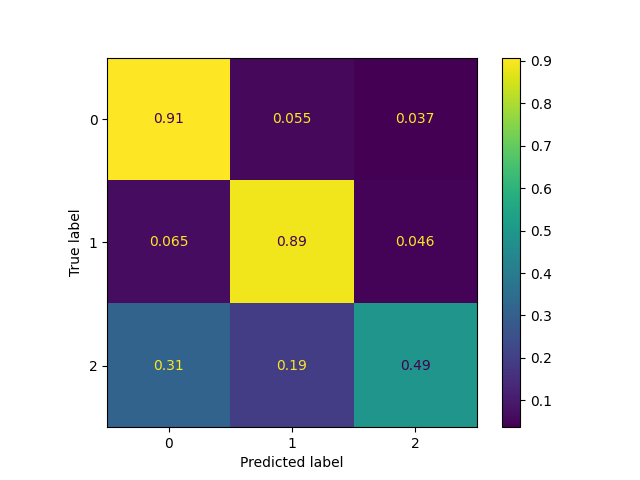

In [10]:
#plot confusion matrix. normalize w.r.t. true values
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(tot_lab.reshape([-1]),tot_pred.reshape([-1]),normalize='true')